<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Extended-Functional-Groups-(EFGs)" data-toc-modified-id="Extended-Functional-Groups-(EFGs)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Extended Functional Groups (EFGs)</a></span><ul class="toc-item"><li><span><a href="#Fragmentation-on-molecules" data-toc-modified-id="Fragmentation-on-molecules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fragmentation on molecules</a></span></li><li><span><a href="#Obtain-EFGs-from-a-dataset" data-toc-modified-id="Obtain-EFGs-from-a-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Obtain EFGs from a dataset</a></span></li><li><span><a href="#Decompose-a-molecule-based-on-current-vocabulary" data-toc-modified-id="Decompose-a-molecule-based-on-current-vocabulary-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Decompose a molecule based on current vocabulary</a></span></li></ul></li></ul></div>

# Extended Functional Groups (EFGs)

Check the version:

In [1]:
import EFGs
EFGs.__version__

'0.8.4'

## Fragmentation on molecules

In [2]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from EFGs import mol2frag

Obtain a `mol` object with `rdkit`:

In [3]:
mol = Chem.MolFromSmiles('CC1=CC2=C(C(=C1)O)C(=O)C3=C(C2=O)C=CC=C3O')
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())

Simply call `mol2frag` can excute basic decomposition on a molecule.

The philosophy of EFG (Extended functional group) is to do fragmentation on molecules so that all fragments of the molecule are **chemical valid**. To do that, we:
1. **Identify aromatic structures**. If two atoms shared the same aromatic ring system, they would be merged.
2. **Identify special substructures**:
    * Mark all heteroatoms in a molecule
    * Mark ‘special’ carbon atoms (carbon atoms with double/triple bonds, acetal carbons and three-membered heterocycles.)
    * Merge all connected marked atoms to a single functional group
3. **Identify simple carbon chains**: sp3 carbons connected by two or more hydrogens
4. **Other single atoms**
The number of single atoms can be significantly reduced by defining subclasses and merging some of them together. All atoms are classified by their aromaticity, degree and formal charge and recorded as element symbol followed by three number corresponding to above properties. For example, Hydrogen ($H_2$) would be H010, methyl group would be C010.

In [4]:
mol2frag(mol)

(['O', 'C=O', 'C=O', 'O', 'c1ccccc1', 'c1ccccc1'], ['C010'])

By default, the result returns a tuple of two lists: The first contains functional groups and the second contains the extended part. But you can also set `returnidx=True` so that it would also return atom indices:

['O', 'C=O', 'C=O', 'O', 'c1ccccc1', 'c1ccccc1'] ['C010'] [(7,), (8, 9), (12, 13), (18,), (1, 2, 3, 4, 5, 6), (16, 17, 10, 11, 14, 15)] [(0,)]


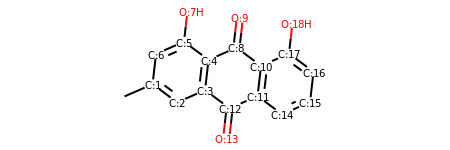

In [5]:
print(*mol2frag(mol, returnidx=True))
display(mol)

## Obtain EFGs from a dataset

In [6]:
# Load data
import pickle
with open("QM9smiles.pt",'rb') as file: 
    qm9 = pickle.load(file)

`qm9` is a list of smiles:

In [7]:
len(qm9), qm9[:10]

(133246, ['C', 'N', 'O', 'C#C', 'C#N', 'C=O', 'CC', 'CO', 'CC#C', 'CC#N'])

First those molecules would go through initial fragmentation:
<br>
* mol2frag helps to find fragments in molecules
* counter is used to store vocabulary frequency

Below is just one example with explicit Hs been taken into consideration. There are lots of available options:
```python
def mol2frag(raw_mol, TreatHs='ignore', returnidx=False, toEnd=False, vocabulary=(), extra_included=False, isomericSmiles=True, extra_backup={})
    '''
    raw_mol: rdkit mol object to be decompose
    TreatHs: (optional) The way to treat Hs. Default: 'ignore' (Other options: 'separate': treat Hs separately; 'include': merged to neighboring EFGs) 
    returnidx: (optional) Whether cooresponding atom index of EFGs shouls be returned. (Default=False)
    toEnd: Whether to decompose to the end. (Default=False, will only do 1-step decomposition)
    vocabulary: (optional) A list of smiles which contains EFGs. This argument would be ignore if 
    toEnd=False. If toEnd is set to True, this argument is required. (Default=None)
    extra_included: (optional) If fragments outside of vocabulary should be parsed. (Default=False, will throw
    an error if a fragment cannot be found in vocabulary). When it is set to True, additional fragments
    would be simply classified based on their aromaticity.
    isomericSmiles: (optional) include information about stereochemistry in the SMILES.
    extra_backup: (optional) If an empty dictionary is provided, additional fragments' smiles would be added. 
    return:
    Functional groups' smiles (or 'Aromatic'/'Non-aromatic') and C/Hs
    (or)
    Functional groups' smiles (or 'Aromatic'/'Non-aromatic'), C/Hs, atom indices of funtional groups
    and CHs (if returnidx=True)
    '''
```

In [8]:
from collections import Counter

In [9]:
word = Counter()
for smiles in qm9:
    mol = Chem.MolFromSmiles(smiles)
    a,b=mol2frag(mol)
    word.update(a+b)

Now we get a EFG vocabulary of size 2681:

In [10]:
len(word)

2681

In [11]:
word.most_common(10)

[('C030', 162701),
 ('C020', 117444),
 ('C010', 98578),
 ('O', 84719),
 ('C040', 47981),
 ('CC', 42102),
 ('C=O', 21402),
 ('N', 20302),
 ('C#N', 14348),
 ('C#C', 14129)]

We can save a total vocabulary library:

In [12]:
file = open('initial_vocab.pt', 'wb') 
pickle.dump(word,file) 
file.close() 

If the initial vocabulary is way too large, we can do further fragmentation for those EFGs with low frequency:

The default value for parameter `alpha` is 0.7, which means those EFGs ranking after 0.7\*len(vocab) would be further decomposed.
```python
def cleavage(dictionary, alpha = 0.7, isomericSmiles=True)
```

In [13]:
from EFGs import cleavage
cleavage(word)

So here we got our reduced vocabulary.

In [14]:
len(word)

1186

## Decompose a molecule based on current vocabulary

We will still use the same function: mol2frag

You can pass a list to `mol2frag` so the decomposition would based on EFGs in the provided list. In that case, you need to set `toEnd=True` to allow further decomposition. Sometimes an EFG could be too large to find exact match, while whose substructures may have been included.

`WordNotFound Error` would be raised if an EFG is not provided in vocabulary, to avoid this, you can set `extra_included=True`. If you want to keep track of those exceptions, you can pass a dictionary to `extra_backup`.

In [15]:
mol = Chem.MolFromSmiles('[O-]C(=O)C1=CNC(=[NH2+])N1')
mol2frag(mol, toEnd=True, vocabulary=list(word))

WordNotFoundError: {'[NH2+]=c1[nH]cc[nH]1'} not found.

In [16]:
my_backup = {}
fgs = mol2frag(mol, toEnd=True, vocabulary=list(word), extra_included=True, extra_backup=my_backup)
print(fgs)
print(my_backup)

(['O=C[O-]', 'Aromatic'], [])
{'Aromatic': {'[NH2+]=c1[nH]cc[nH]1'}}


Let's take a look at the coverage of our current reduced EFGs:

In [17]:
extra = 0
for smiles in qm9:
    mol = Chem.MolFromSmiles(smiles)
    try:
        mol2frag(mol, toEnd=True, vocabulary=list(word))
    except:
        extra += 1

In [18]:
len(word)/len(qm9), 1-extra/len(qm9)

(0.00890083004367861, 0.9946640049232247)

Now we have a EFG library with only 0.9% original size but have a coverage > 99.5%